# Các mẫu thiết kế GOF : Strategy

**BS. Lê Ngọc Khả Nhi**

# Giới thiệu

Strategy (Chiến thuật) là một mẫu thiết kế thuộc nhóm Hành vi, cho phép ta thiết lập những quy trình/thuật toán khác nhau nhằm giải quyết cùng một công việc theo nhiều cách thức, và đặt mỗi quy trình này vào những class riêng biệt, có thể hoán chuyển.

# Thí dụ minh họa

Trong các nghiên cứu lâm sàng chuyên khoa Hô hấp, những thông số chức năng hô hấp, thí dụ FEV1, dung tích phổi, TLCO... thường được khảo sát bằng thang đo chuẩn hóa (Z-scores) hoặc % giá trị dự báo (%Pred), thay vì giá trị đo được.

Một số nghiên cứu sinh (NCS) chọn cách nhập liệu trực tiếp Z-score hay %Pred từ phiếu xét nghiệm, thậm chí bỏ qua không lấy giá trị đo được. Tuy nhiên cách làm này không hay, vì ta không chắc chắn về mô hình nào đã được dùng để tính giá trị tham chiếu, và mô hình này có thể khác biệt giữa các thiết bị xét nghiệm. Nó có thể gây ra vấn đề phiền toái sau này, nếu như người bình duyệt yêu cầu tính Z-score theo một mô hình chuyên biệt nào đó. 

Cách làm chuyên nghiệp và tối ưu, đó là NCS cần nhập liệu đủ các thông số như Giới tính, tuổi, chiều cao, cân nặng..., cho phép ước tính giá trị tham chiếu theo bất kì mô hình nào; kèm theo giá trị đo được thực tế của chỉ số chức năng, thí dụ TLCO hay FEV1. Với dữ liệu này, ta có thể dùng bất cứ mô hình nào để tính Z-score hay %Pred.

Nhưng ta sẽ làm điều đó như thế nào ?

Trong thí dụ sau, một NCS muốn dùng 2 mô hình khác nhau là Koopman (2011) và BTS-ERS (1993) để tính Z-score cho TLCO riêng cho bệnh nhân trẻ em và người lớn, từ dữ liệu thô của mình. 

Cách làm đầu tiên mà nhiều bạn nghĩ đến, đó là dùng 1 hàm (function) duy nhất, trong đó phân ra 2 nhánh bằng điều kiện if... else... để tính Z-score từ dữ liệu đầu vào. 

Nhưng trong bài này, Nhi sẽ hướng dẫn các bạn sử dụng mẫu thiết kế Strategy để giải quyết vấn đề trên bằng cách tiếp cận OOP.

# Giải quyết vấn đề bằng thiết kế Strategy

Phân tích vấn đề, ta thấy rằng: Tuy chỉ có 1 mục tiêu (kết quả đầu ra) của việc tính toán, đó là Z-scores, nhưng khi áp dụng mô hình Koopman hoặc ERS, ta thực hiện 2 quy trình tính toán rất khác nhau:

Ngoài nội dung mô hình khác nhau, phương pháp tính Z-score cũng khác nhau: 
mô hình Koopman sử dụng phương pháp tính Z-score từ 3 tham số Lambda-Mu-Sigma (phân phối Box-Cox-Cole-Green, BCCG), mô hình ERS tính Z-score từ giá trị trung bình dự báo Mu và Residual SD (RSD), dựa theo giả định phân phối chuẩn hóa.

Ta sẽ thiết kế riêng 2 class riêng biệt: Child_strategy và Adult_strategy, mỗi class vận dụng method cùng tên là interpret() để tính Z-score theo 2 mô hình khác nhau.

Ta vận hành quy trình thông qua class TLCO_interpreter, bên trong class này có 2 fields là data và strategy, trong đó field strategy có giá trị là 1 trong 2 class Child,Adult ở trên, quy định "chiến thuật" hay phương pháp nào sẽ được sử dụng. Ta sẽ dùng property và method setter để strategy có thể được thay đổi ở cấp độ instance, cho phép thay strategy hiện hành bằng 1 strategy khác (hoán chuyển).

Sơ đồ UML của chương trình như sau:

!['uml'](strategy_UML.png)

Nội dung của code nằm tại thư mục Github sau:

https://github.com/kinokoberuji/Python-snipets/blob/master/GOF/Strategy/strategy.py

2 hàm cho 2 mô hình Koopman và BTS-ERS như sau:

In [ ]:
def koopman_tlco(x : np.array):

    '''Mô hình Koopman (2011), dành cho trẻ em từ 5-18 tuổi
    ước lượng 3 tham số Mu, Lambda, Sigma của DLCO theo phân phối Gamma chuẩn hóa
    '''

    sex = x[0]
    A = x[1]
    H = x[2]
    
    if sex == 1:
        M = (np.exp(34.8048-6.8925*np.log(H)-8.6557*np.log(12*A)+0.1043+1.7893*np.log(H)*np.log(12*A)))/0.3348
        L = np.exp(-1.63-0.0348*A)
        S = 2/(1/(np.exp(-1.63-0.0348*A))**2)**0.5
    else:
        M = (np.exp(34.8048-6.8925*np.log(H)-8.6557*np.log(12*A)+1.7893*np.log(H)*np.log(12*A)))/0.3348
        L = np.exp(-2.38+0.0276*A)
        S = 2/(1/(np.exp(-1.63-0.0348*A))**2)**0.5
    
    return M,L,S

def bts_ers_tlco(x : np.array):

    '''Mô hình BTS-ERS (1993) của Cotes và Quanjer,
    ước lượng trung bình dự báo Mu của LDCO theo phân phối chuẩn
    Áp dụng cho người lớn từ 18-75 tuổi
    '''
    
    sex = x[0]
    A = x[1]
    H = x[2]
        
    if sex == 1:
        M = 0.325*H-0.2*A-17.6
        se = 5.1
    else:
        M = 0.212*H-0.156*A-2.66
        se = 3.69

    ULN = M + 1.96 * se
    rsd = (ULN - M)/1.96
        
    return M,rsd

2 hàm cho 2 phương pháp tính Z-scores theo LMS và Mu-RSD như sau:

In [ ]:
def RSD_Z_score(feats):

    '''Hàm tính điểm Z-score dựa vào Mu và RSD
    '''
    M = feats[0]
    rsd = feats[1]
    obs = feats[2]
    
    Z= (obs-M)/rsd
    
    return Z

def LMS_Z_score(feats):

    '''Hàm tính điểm Z-score dựa vào 3 tham số Mu, Lambda, Sigma
    '''

    M = feats[0]
    L = feats[1]
    S = feats[2]
    obs = feats[3]
                
    Z=((obs/M)**L-1)*(1/(L*S))

    return Z

Nội dung thiết kế Strategy:

In [ ]:
@dataclass
class TLCO_interpreter:

    _strategy: Strategy = field(init=True)
    data: pd.DataFrame = field(init=True)

    @property
    def strategy(self) -> Strategy:
        return self._strategy
    
    @strategy.setter
    def strategy(self, strategy: Strategy) -> None:
        self._strategy = strategy

    def transform(self, targ:str) -> pd.DataFrame:

        data = self.data
        output = self.strategy.interpret(df = data, targ=targ)
        return output

class Strategy(ABC):

    @abstractmethod
    def interpret(self, df: pd.DataFrame, targ:str) -> pd.Series:
        pass

class Child_strategy(Strategy):
    
    def interpret(self, df: pd.DataFrame, targ: str) -> pd.Series:
        
        input_df = df[['Sex','Age','Height']]
        pred_df = input_df.apply(koopman_tlco, axis=1)

        pred_df = pd.DataFrame([[*t] for t in pred_df.values], columns = ['M','L','S'])
        pred_df['Obs'] = df[targ].values

        Z_df = pred_df.apply(LMS_Z_score, axis = 1)

        return Z_df

class Adult_strategy(Strategy):

    def interpret(self, df: pd.DataFrame, targ: str) -> pd.Series:
        
        input_df = df[['Sex','Age','Height']]

        pred_df = input_df.apply(bts_ers_tlco,axis = 1)
        pred_df = pd.DataFrame([[*t] for t in pred_df.values], columns = ['M','RSD'])

        pred_df['Obs'] = df[targ]

        Z_df = pred_df.apply(RSD_Z_score, axis = 1)

        return Z_df

# Sử dụng chương trình

Khi sử dụng chương trình, đầu tiên Nhi import module strategy.py và tải dữ liệu tlco.csv

Nhi cắt data gốc thành 2 phần cho 2 nhóm Nhi khoa và người lớn

In [1]:
from strategy import *

In [2]:
path = 'https://raw.githubusercontent.com/kinokoberuji/Python-snipets/master/GOF/Strategy/tlco.csv'

data = pd.read_csv('tlco.csv',sep = ';', decimal = '.')

data_child = data[data['Age'] < 19]
data_adult = data[data['Age'] >= 19]

Ta khởi tạo 2 instance của 2 strategy classes:

In [26]:
child_method = Child_strategy()
adult_method = Adult_strategy()

Tiếp theo, ta khởi tạo instance tlco_interp, với data là toàn bộ data gốc, và 1 strategy nào đó, thí dụ là adult_method

In [34]:
tlco_interp = TLCO_interpreter(data = data,
                               _strategy = adult_method)

Giả định NCS chỉ sử dụng duy nhất 1 mô hình BTS-ERS cho toàn bộ dữ liệu, lúc này ta chỉ cần dùng method transform với argument targ = 'DLCO':

In [35]:
pred_df = data.copy()

pred_df['Z_adult'] = tlco_interp.transform('DLCO').values

Kết quả có vẻ rất tốt đẹp, ta đã tính được Z-score DLCO cho toàn bộ bệnh nhân, nhưng ở đây ta chỉ áp dụng cùng 1 mô hình BTS-ERS và cùng 1 method Mean-RSD để tính Z_score.

In [36]:
pred_df

,Age,Height,DLCO,Sex,Group,Z_adult
0,20,173.0,34.040744,0,A,0.852234
1,22,165.0,29.718514,0,A,0.225072
2,22,168.6,30.369374,0,A,0.194627
3,23,164.0,29.275962,0,A,0.204868
4,24,170.0,32.705506,0,A,0.831844
...,...,...,...,...,...,...
1269,34,175.0,29.407624,1,B,-0.601446
1270,16,174.0,28.803467,1,B,-1.362065
1271,15,183.0,31.617053,1,B,-1.423127
1272,13,170.0,22.779693,1,B,-2.405943


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def kde_plot(data: pd.DataFrame, targ: str):
    
    plt.figure(figsize = (8,4))
    
    for k in data.Group.unique():
        temp_df = data[data['Group'] == k]
        sns.kdeplot(temp_df[targ], shade = True, alpha = 0.5, label = k)
    
    plt.legend()
    plt.show()

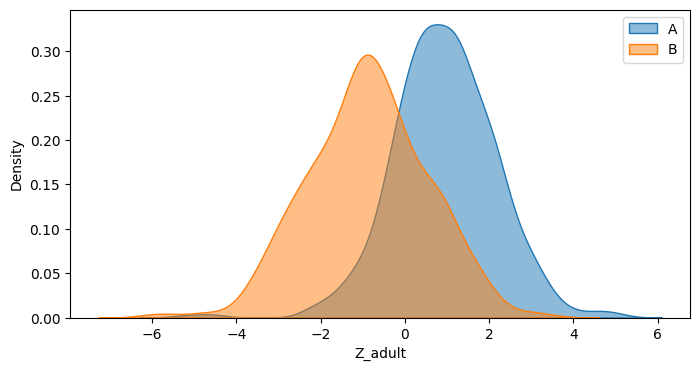

In [37]:
kde_plot(data = pred_df, targ = 'Z_adult')

Tiếp theo, ta sẽ hoán chuyển strategy thành child_method cho riêng nhóm bệnh nhân Nhi khoa:

Ta nhận thấy rằng chỉ có tên strategy là thay đổi, method được vận hành vẫn là transform():

In [46]:
pediatric_interp = TLCO_interpreter(data = data_child, 
                                    _strategy = child_method)

child_pred = data_child.copy()

child_pred['Z-score'] = pediatric_interp.transform('DLCO').values

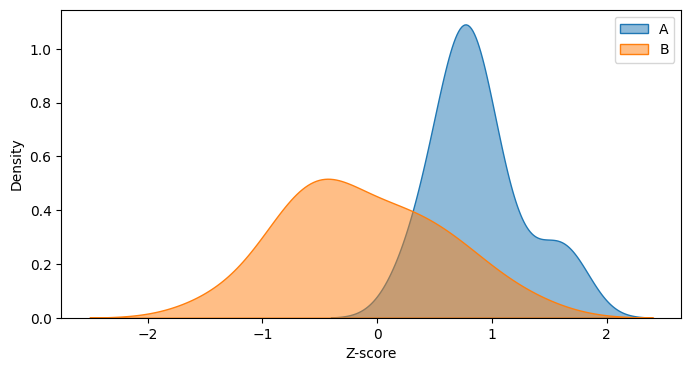

In [47]:
kde_plot(data = child_pred, targ = 'Z-score')

Giả định ban đầu ta dùng 1 instance tlco_interp với method là child_method, cho dữ liệu data cho toàn bộ bệnh nhân

In [39]:
tlco_interp = TLCO_interpreter(data = data, 
                           _strategy = child_method)

Ta có thể hoán chuyển strategy và data cho instance tlco_interp như sau:

Gán data_adult cho field data,

Gán adult_method cho field strategy

Lúc này, instance tlco_interp sẵn sàng dùng cho đối tượng bệnh nhân người lớn:

In [42]:
tlco_interp.data = data_adult

tlco_interp.strategy = adult_method # setter 

In [44]:
tlco_interp.data

,Age,Height,DLCO,Sex,Group
0,20,173.0,34.040744,0,A
1,22,165.0,29.718514,0,A
2,22,168.6,30.369374,0,A
3,23,164.0,29.275962,0,A
4,24,170.0,32.705506,0,A
...,...,...,...,...,...
1266,84,169.0,12.258934,1,B
1267,60,170.0,23.560163,1,B
1268,44,178.0,26.737258,1,B
1269,34,175.0,29.407624,1,B


In [43]:
tlco_interp.strategy

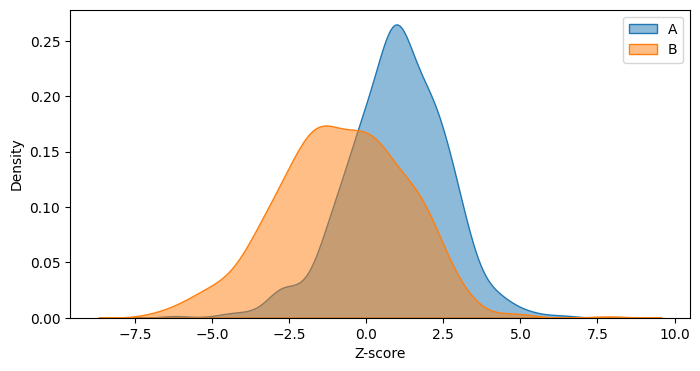

In [48]:
adult_pred = data_adult.copy()

adult_pred['Z-score'] = tlco_interp.transform('DLCO').values

kde_plot(data = adult_pred, targ = 'Z-score')

Hình ảnh phân phối của Z-scores khi sử dụng 2 mô hình riêng biệt, nó khác với khi chỉ sử dụng 1 mô hình duy nhất (như ở trên)

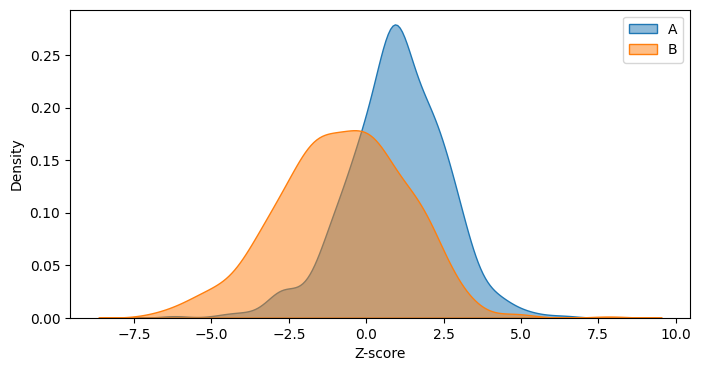

In [49]:
kde_plot(data = pd.concat([adult_pred, child_pred]), 
         targ = 'Z-score')

# Tổng kết

## Ứng dụng

Mẫu thiết kế Strategy rất đơn giản về kỹ thuật, và có thể hữu ích trong một số hoàn cảnh, khi bạn muốn làm một việc bằng nhiều cách thức khác nhau, hay dùng nhiều biến thể khác nhau của một algorithm qua một class và có thể hoán chuyển giữa các cách thức này, mà không cần phải thay đổi nội dung mã nguồn của class.


## Ưu điểm và nhược điểm của mẫu thiết kế Strategy:

**Ưu điểm**

Tính độc lập giữa hành động tổng quát và hành vi, thỏa mãn nguyên tắc Open/Closed (cho phép phát triển thêm tính năng, hành vi mới nhưng không làm thay đổi nội dung code hiện thời).

Khi dùng Strategy, ta tách rời hành động thực hiện quy trình, và nội dung chi tiết/các biến thể của quy trình đó. Điều này cho phép ta tạo ra thêm nhiều biến thể (strategy khác) một cách độc lập với tiến trình sử dụng. Trong thí dụ trên, nếu một ngày đẹp trời nào đó chuyên gia bình duyệt yêu cầu NCS sử dụng mô hình tham chiếu GLI 2017 của ATS/ERS, NCS chỉ cần viết thêm 1 class GLI_strategy mới, nhưng không cần phải thay đổi mã nguồn của class TLCO_Interpreter.

Có thể hoán chuyển strategy field dễ dàng ở cấp độ instance/object; Có thể thiết kế theo inheritance hoặc composition

Mẫu thiết kế này cũng cho phép ta thay thế những cấu trúc điều kiện if...else phức tạp mà ta vẫn thường thấy nếu chỉ dùng 1 hàm hay method duy nhất cho nhiều hoàn cảnh khác nhau.

**Nhược điểm**

Có thể tạo ra quá nhiều class nhỏ, mà nội dung chỉ khác biệt chút ít, nên cân nhắc về sự cần thiết mở rộng về lâu dài và sự ngắn gọn tinh giản của mã nguồn hiện hành để lựa chọn giữa hàm đơn và OOP dùng mẫu Strategy. Nếu bạn chuộng lập trình hàm, có thể dùng hàm lambda để thay thế cho Strategy pattern (Hàm lambda cũng cho phép gọi những method khác nhau trên cùng dữ liệu đầu vào)

Người dùng cần được thông tin về sự tồn tại của nhiều strategies khác nhau, và sự khác biệt về hành vi giữa chúng.

Bài thực hành tạm dừng, chúc các bạn học vui và hẹn gặp lại.